In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Zero-shot object detection

Traditionally, models used for [object detection](https://huggingface.co/docs/transformers/main/en/tasks/object_detection) require labeled image datasets for training,
and are limited to detecting the set of classes from the training data.

Zero-shot object detection is supported by the [OWL-ViT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/owlvit) model which uses a different approach. OWL-ViT
is an open-vocabulary object detector. It means that it can detect objects in images based on free-text queries without
the need to fine-tune the model on labeled datasets.

OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines [CLIP](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/clip) with
lightweight object classification and localization heads. Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads.
associate images and their corresponding textual descriptions, and ViT processes image patches as inputs. The authors
of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using
a bipartite matching loss.

With this approach, the model can detect objects based on textual descriptions without prior training on labeled datasets.

In this guide, you will learn how to use OWL-ViT:
- to detect objects based on text prompts
- for batch object detection
- for image-guided object detection

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q transformers
```

## Zero-shot object detection pipeline

The simplest way to try out inference with OWL-ViT is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a pipeline
for zero-shot object detection from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?other=owlvit):

In [2]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Device set to use cuda:0


Next, choose an image you'd like to detect objects in. Here we'll use the image of astronaut Eileen Collins that is
a part of the [NASA](https://www.nasa.gov/multimedia/imagegallery/index.html) Great Images dataset.

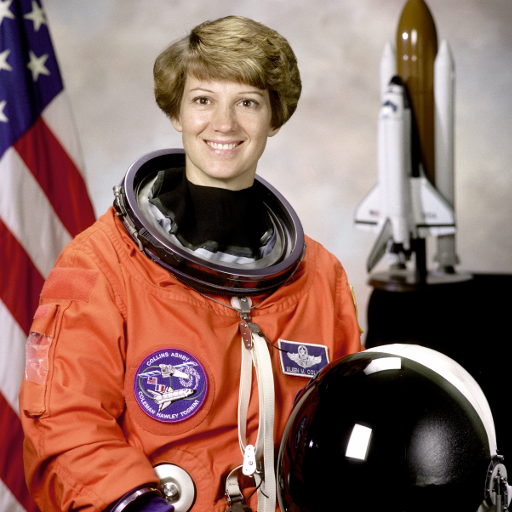

In [3]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_1.png" alt="Astronaut Eileen Collins"/>
</div>

Pass the image and the candidate object labels to look for to the pipeline.
Here we pass the image directly; other suitable options include a local path to an image or an image url. We also pass text descriptions for all items we want to query the image for.

In [ ]:
predictions = detector(
    image,
    candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],
)
predictions

[{'score': 0.3571370542049408,
  'label': 'human face',
  'box': {'xmin': 180, 'ymin': 71, 'xmax': 271, 'ymax': 178}},
 {'score': 0.28099656105041504,
  'label': 'nasa badge',
  'box': {'xmin': 129, 'ymin': 348, 'xmax': 206, 'ymax': 427}},
 {'score': 0.2110239565372467,
  'label': 'rocket',
  'box': {'xmin': 350, 'ymin': -1, 'xmax': 468, 'ymax': 288}},
 {'score': 0.13790413737297058,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': 1, 'xmax': 105, 'ymax': 509}},
 {'score': 0.11950037628412247,
  'label': 'nasa badge',
  'box': {'xmin': 277, 'ymin': 338, 'xmax': 327, 'ymax': 380}},
 {'score': 0.10649408400058746,
  'label': 'rocket',
  'box': {'xmin': 358, 'ymin': 64, 'xmax': 424, 'ymax': 280}}]

Let's visualize the predictions:

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_2.png" alt="Visualized predictions on NASA image"/>
</div>

## Text-prompted zero-shot object detection by hand

Now that you've seen how to use the zero-shot object detection pipeline, let's replicate the same
result manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?other=owlvit).
Here we'll use the same checkpoint as before:

In [5]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

Let's take a different image to switch things up.

In [ ]:
import requests

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
im

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png" alt="Beach photo"/>
</div>

Use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the
image for the model by resizing and normalizing it, and a [CLIPTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/clip#transformers.CLIPTokenizer) that takes care of the text inputs.

In [ ]:
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

Pass the inputs through the model, post-process, and visualize the results. Since the image processor resized images before
feeding them to the model, you need to use the [post_process_object_detection()](https://huggingface.co/docs/transformers/main/en/model_doc/owlvit#transformers.OwlViTImageProcessor.post_process_object_detection) method to make sure the predicted bounding
boxes have the correct coordinates relative to the original image:

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_4.png" alt="Beach photo with detected objects"/>
</div>

## Batch processing

You can pass multiple sets of images and text queries to search for different (or same) objects in several images.
Let's use both an astronaut image and the beach image together.
For batch processing, you should pass text queries as a nested list to the processor and images as lists of PIL images,
PyTorch tensors, or NumPy arrays.

In [ ]:
images = [image, im]
text_queries = [
    ["human face", "rocket", "nasa badge", "star-spangled banner"],
    ["hat", "book", "sunglasses", "camera"],
]
inputs = processor(text=text_queries, images=images, return_tensors="pt")

Previously for post-processing you passed the single image's size as a tensor, but you can also pass a tuple, or, in case
of several images, a list of tuples. Let's create predictions for the two examples, and visualize the second one (`image_idx = 1`).

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = [x.size[::-1] for x in images]
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)

image_idx = 1
draw = ImageDraw.Draw(images[image_idx])

scores = results[image_idx]["scores"].tolist()
labels = results[image_idx]["labels"].tolist()
boxes = results[image_idx]["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[image_idx][label]}: {round(score,2)}", fill="white")

images[image_idx]

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_4.png" alt="Beach photo with detected objects"/>
</div>

## Image-guided object detection

In addition to zero-shot object detection with text queries, OWL-ViT offers image-guided object detection. This means
you can use an image query to find similar objects in the target image.
Unlike text queries, only a single example image is allowed.

Let's take an image with two cats on a couch as a target image, and an image of a single cat
as a query:

In [12]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open("townsend.png").convert("RGB")

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open("icon_switch.png").convert("RGB")

Let's take a quick look at the images:

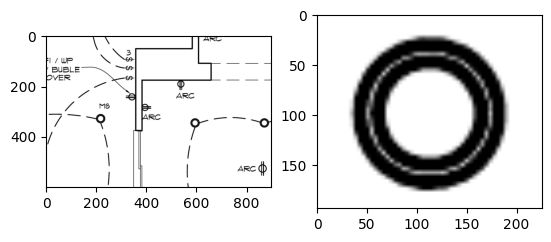

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_5.png" alt="Cats"/>
</div>

In the preprocessing step, instead of text queries, you now need to use `query_images`:

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [7]:
from PIL import ImageDraw


In [14]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

For predictions, instead of passing the inputs to the model, pass them to [image_guided_detection()](https://huggingface.co/docs/transformers/main/en/model_doc/owlvit#transformers.OwlViTForObjectDetection.image_guided_detection). Draw the predictions
as before except now there are no labels.

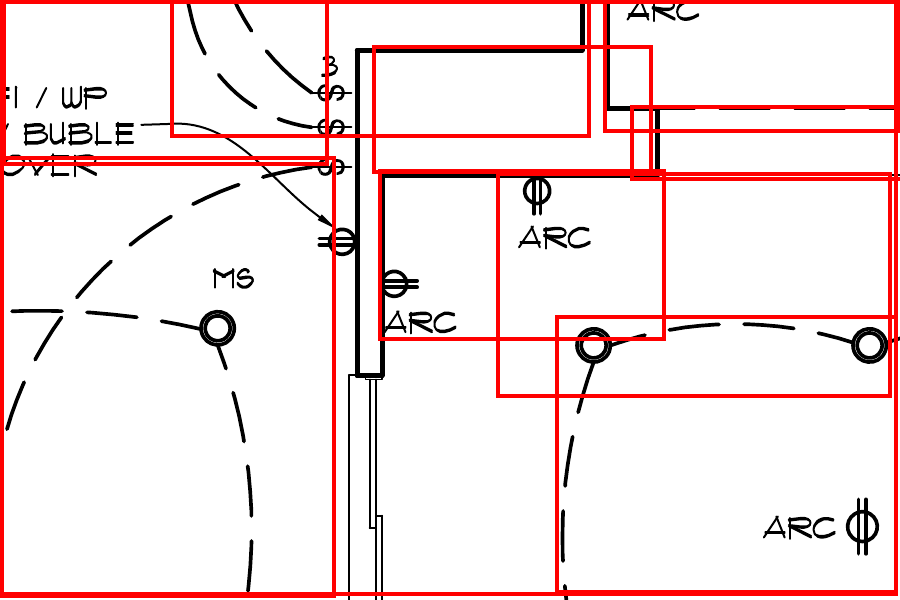

In [18]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=4)

image_target